In [1]:
import sys
sys.path.append('../../utils')
from functions import * 

In [2]:
from importlib import reload
import sys

# Path to the Leaflet repository
PATH_TO_LEAFLET_REPO = '/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/'
sys.path.append(PATH_TO_LEAFLET_REPO)

In [3]:
import cell_state_asign_consistency
reload  (cell_state_asign_consistency)

<module 'cell_state_asign_consistency' from '/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/cell_state_asign_consistency.py'>

In [4]:
import betabinomo_mix_singlecells
reload (betabinomo_mix_singlecells)

<module 'betabinomo_mix_singlecells' from '/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/betabinomo_mix_singlecells.py'>

In [5]:
# reload load_cluster_data
import load_cluster_data
reload (load_cluster_data)

<module 'load_cluster_data' from '/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/load_cluster_data.py'>

In [6]:
from importlib import reload
#from load_cluster_data import load_cluster_data
from betabinomo_mix_singlecells import *
#reload(betabinomo_mix_singlecells)
from cell_state_asign_consistency import *
#reload(cell_state_asign_consistency)
import torch
import sklearn.manifold 
import plotnine as p9
import time
# indicate plot should be small 4 by 4
import plotnine as p9
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_violin, theme, element_blank, geom_text, geom_bar, geom_hline
import plotnine
from tqdm import tqdm
plotnine.options.figure_size = (4, 4)
import seaborn as sns
sns.set_theme(style="whitegrid")

/gpfs/commons/home/kisaev/.local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### Settings and Load data

In [7]:
torch.manual_seed(42)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

K = 50 # set to very high number 

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

hypers = {
    "eta" : 1./K, 
    "alpha_prior" : 1., # karin had 0.65 
    "pi_prior" : 1.
}

print(hypers["eta"])

cpu
0.02


### load_cluster_data takes ~ 5 minutes for ss2 brain data.... 

In [8]:
cell_types = ['Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte',
       'Brain_Non-Myeloid_oligodendrocyte',
       'Brain_Non-Myeloid_endothelial_cell', 'Brain_Non-Myeloid_neuron',
       'Brain_Non-Myeloid_oligodendrocyte_precursor_cell',
       'Brain_Non-Myeloid_brain_pericyte', 'Brain_Myeloid_macrophage']
print(cell_types)

['Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte', 'Brain_Non-Myeloid_oligodendrocyte', 'Brain_Non-Myeloid_endothelial_cell', 'Brain_Non-Myeloid_neuron', 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell', 'Brain_Non-Myeloid_brain_pericyte', 'Brain_Myeloid_macrophage']


In [9]:
# this folder contains input data for each tissue cell type sample
input_files_folder = '/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/'

final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data.load_cluster_data(
    input_folder = input_files_folder, has_genes="yes", celltypes=cell_types) 

Reading in data from folder ...
/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/
Finished reading in data from folder ...
Looking at only specific cell types ...['Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte', 'Brain_Non-Myeloid_oligodendrocyte', 'Brain_Non-Myeloid_endothelial_cell', 'Brain_Non-Myeloid_neuron', 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell', 'Brain_Non-Myeloid_brain_pericyte', 'Brain_Myeloid_macrophage']
['Brain_Non-Myeloid_brain_pericyte'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell'
 'Brain_Non-Myeloid_endothelial_cell' 'Brain_Non-Myeloid_oligodendrocyte'
 'Brain_Non-Myeloid_neuron' 'Brain_Myeloid_macrophage'
 'Brain_Myeloid_microglial_cell' 'Brain_Non-Myeloid_astrocyte']
7816
16190
                                             cell_id  Cluster  Cluster_Counts  \
0  A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...        4              21   
1  A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...

In [10]:
len(final_data.junction_id_index.unique())

16191

In [11]:
junction_ids_conversion.head()

,junction_id_index,junction_id,Cluster,gene_id
0,0,1_160044753_160070699,4,4930523C07Rik
1,1,1_160070803_160075030,4,4930523C07Rik
2,2,1_155567681_155572197,10,Acbd6
3,3,1_36307836_36316208,27,Arid5a
4,4,1_36316327_36317609,28,Arid5a


In [12]:
print(final_data.cell_type.unique())

['Brain_Non-Myeloid_brain_pericyte'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell'
 'Brain_Non-Myeloid_endothelial_cell' 'Brain_Non-Myeloid_oligodendrocyte'
 'Brain_Non-Myeloid_neuron' 'Brain_Myeloid_macrophage'
 'Brain_Myeloid_microglial_cell' 'Brain_Non-Myeloid_astrocyte']


In [13]:
print("The number of junctions is: ", len(junction_ids_conversion))
print("The number of intron clusters observed is: ", len(junction_ids_conversion.Cluster.unique()))
print("The number of genes is: ", len(junction_ids_conversion.gene_id.unique()))

The number of junctions is:  16191
The number of intron clusters observed is:  5433
The number of genes is:  4135


In [14]:
final_data.head()

,cell_id_index,junction_id_index,junc_count,cluster_count,clustminjunc,juncratio,cell_id,cell_type
0,0,0,11.0,21,10.0,0.523810,A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...,Brain_Non-Myeloid_brain_pericyte
1,0,1,10.0,21,11.0,0.476190,A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...,Brain_Non-Myeloid_brain_pericyte
2,0,2,16.0,16,0.0,1.000000,A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...,Brain_Non-Myeloid_brain_pericyte
3,0,3,7.0,7,0.0,1.000000,A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...,Brain_Non-Myeloid_brain_pericyte
4,0,4,5.0,12,7.0,0.416667,A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...,Brain_Non-Myeloid_brain_pericyte


In [15]:
# ensure that in coo_counts_sparse.shape = (n_cells, n_genes) , n_cells is the same number as cell_ids_conversion.shape = (n_cells, num_variables)
assert coo_counts_sparse.shape[0] == cell_ids_conversion.shape[0]

In [16]:
cell_index_tensor, junc_index_tensor, my_data = make_torch_data(final_data, **float_type)

The number of cells going into training data is:
7816
7816


/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/betabinomo_mix_singlecells.py:333: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)


In [17]:
cell_ids_conversion.head()
# what is the breadkdown of cell types in the data 
cell_ids_conversion['cell_type'].value_counts()

Brain_Myeloid_microglial_cell                       4394
Brain_Non-Myeloid_oligodendrocyte                   1574
Brain_Non-Myeloid_endothelial_cell                   715
Brain_Non-Myeloid_astrocyte                          432
Brain_Non-Myeloid_neuron                             281
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     203
Brain_Non-Myeloid_brain_pericyte                     156
Brain_Myeloid_macrophage                              61
Name: cell_type, dtype: int64

In [18]:
# set random seed
torch.manual_seed(0)

num_trials = 10 # should also be an argument that gets fed in
num_iters = 100 # should also be an argument that gets fed in
K = 10

# loop over the number of trials (for now just testing using one trial but in general need to evaluate how performance is affected by number of trials)
#reload(betabinomo_mix_singlecells)

start_time = time.time()

# Running for just one K and assessing similarity across trials 

results = [ calculate_CAVI(K, my_data, float_type, hypers, init_labels = None, num_iterations = num_iters) 
           for t in range(num_trials) ]


# write the above line use fstring
print(f"This took {time.time() - start_time} seconds")

Initialize VI params
Initializing variational parameters with N = 7816 cells and J = 16191 junctions
Got the initial ELBO ^
ELBO converged @ -298414496.0 CAVI iteration # 23 complete
Finished CAVI!
Initialize VI params
Initializing variational parameters with N = 7816 cells and J = 16191 junctions
Got the initial ELBO ^
ELBO converged @ -299093472.0 CAVI iteration # 48 complete
Finished CAVI!
Initialize VI params
Initializing variational parameters with N = 7816 cells and J = 16191 junctions
Got the initial ELBO ^
ELBO converged @ -298416256.0 CAVI iteration # 34 complete
Finished CAVI!
Initialize VI params
Initializing variational parameters with N = 7816 cells and J = 16191 junctions
Got the initial ELBO ^
ELBO converged @ -298944960.0 CAVI iteration # 28 complete
Finished CAVI!
Initialize VI params
Initializing variational parameters with N = 7816 cells and J = 16191 junctions
Got the initial ELBO ^
ELBO converged @ -298748288.0 CAVI iteration # 29 complete
Finished CAVI!
Initialize

In [19]:
running_multiple_K = False 
if running_multiple_K:
    elbos_ks = []
    for i in range(len(all_results_k)):
        print("Reporting ELBO for k = " + str(i+1))
        results = all_results_k[i]
        best = np.argmax([ g[-1][-1] for g in results ]) # best ELBO within trial
        ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = results[best]
        elbos_all = np.array(elbos_all)
        print("ELBO: " + str(elbos_all[-1]))
        elbos_ks.append(elbos_all[-1])
    
    elbos_ks = pd.DataFrame(elbos_ks)
    elbos_ks["k"] = range(K)
    best_k = elbos_ks.sort_values(by=0, ascending=False).head(1)
    results = all_results_k[best_k.index[0]]
    print("The k with the highest ELBO is: " + str(best_k.index[0]+1))
    K = best_k.index[0]+1 
    print(K)

In [20]:
len(results)

10

### Consensus Clustering

In [21]:
sum_matrices = consensus_clustering(results)

# normalize by number of trials
normalized_matrix = sum_matrices / sum_matrices.max() # taking the sum_matrix and dividing by the max value in the matrix

# get distance metric 
distance_matrix = 1 - normalized_matrix
distance_matrix

Got all cells and their assignments based on PHI_f in each trial!
Got a cell by cell matrix for each trial indicating whether cells were coassigned
Getting sum of matrices across all iterations


array([[0. , 0.1, 0.1, ..., 1. , 1. , 1. ],
       [0.1, 0. , 0.1, ..., 1. , 1. , 1. ],
       [0.1, 0.1, 0. , ..., 1. , 1. , 1. ],
       ...,
       [1. , 1. , 1. , ..., 0. , 0.3, 0.2],
       [1. , 1. , 1. , ..., 0.3, 0. , 0.2],
       [1. , 1. , 1. , ..., 0.2, 0.2, 0. ]])

In [22]:
# what is the proportion of 0s and 1s in the distance matrix
print("Proportion of 0s in distance matrix: ", np.count_nonzero(distance_matrix == 0) / (distance_matrix.shape[0] * distance_matrix.shape[1]))
print("Proportion of 1s in distance matrix: ", np.count_nonzero(distance_matrix == 1) / (distance_matrix.shape[0] * distance_matrix.shape[1]))

Proportion of 0s in distance matrix:  0.06633890248489045
Proportion of 1s in distance matrix:  0.5574068139888888


In [23]:
variances_per_cell = np.var(distance_matrix, axis=1)

# Compute the overall measure of consistency
overall_consistency = np.mean(variances_per_cell)

print(overall_consistency)

0.11790914966231757


In [24]:
# cluster distance matrix using hierarchical clustering into K clusters 
from sklearn.cluster import KMeans
# Number of clusters
num_clusters = 10 

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(distance_matrix)

# Your N by K matrix
n_by_k_matrix = np.zeros((distance_matrix.shape[0], num_clusters))

# Fill the N by K matrix with cluster assignments
for i in range(num_clusters):
    n_by_k_matrix[:, i] = (cluster_labels == i).astype(int)

[Text(1, 0.5, '5'),
 Text(1, 1.5, '1'),
 Text(1, 2.5, '9'),
 Text(1, 3.5, '8'),
 Text(1, 4.5, '2'),
 Text(1, 5.5, '3'),
 Text(1, 6.5, '4'),
 Text(1, 7.5, '7'),
 Text(1, 8.5, '0'),
 Text(1, 9.5, '6')]

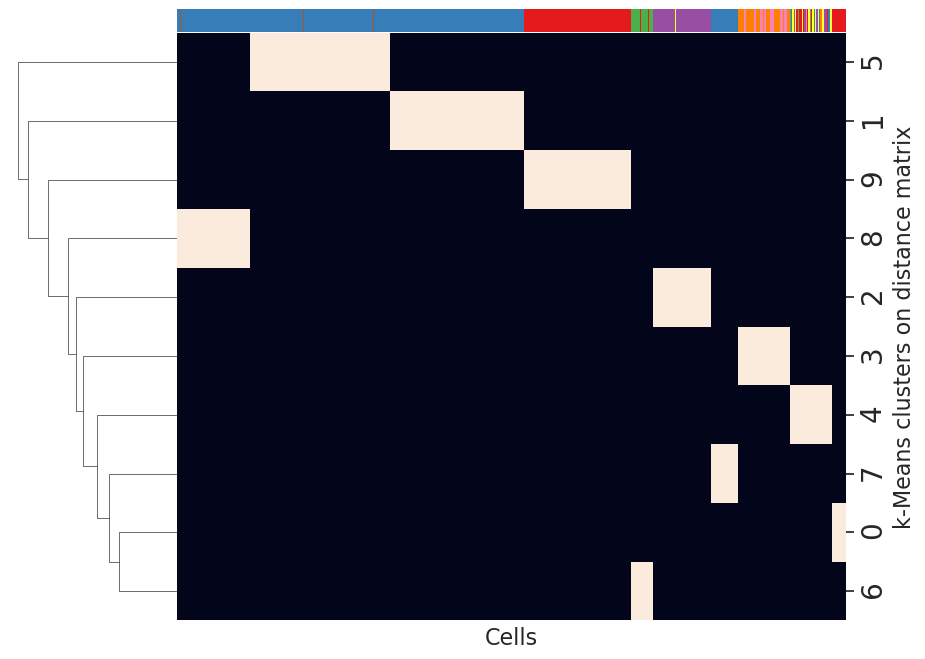

In [25]:
# sample 5200 indices from distance matrix
samp_indices = np.random.choice(cell_ids_conversion.shape[0], 500, replace=False)
cell_types_heatmap = cell_ids_conversion.iloc[samp_indices]

color_palette = sns.color_palette("Set1", n_colors=len(cell_types_heatmap['cell_type'].unique()))

# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)

# Obtain cell type labels for every cell in the matrix also 
unique_cell_types = cell_types_heatmap['cell_type'].unique()
num_unique_types = len(unique_cell_types)
colors = sns.color_palette('Set1', n_colors=num_unique_types)  # You can use any color palette
cell_type_colors = {cell_type: color for cell_type, color in zip(unique_cell_types, colors)}
cell_types = cell_types_heatmap.cell_type.values

# Convert cell types to corresponding colors for rows and columns
row_colors = [cell_type_colors[cell_type] for cell_type in cell_types]
col_colors = [cell_type_colors[cell_type] for cell_type in cell_types]

n_by_k_matrix = n_by_k_matrix.T
n_by_k_matrix[:, samp_indices]

# draw clustermap of sampled_distance_matrix
# Create a clustermap with row colors representing cell types

clustmap = sns.clustermap(
    data=n_by_k_matrix[:, samp_indices],
    method='complete',
    annot=False,
    fmt=".2f",
    xticklabels=False,
    yticklabels=True,
    col_colors=col_colors, 
    figsize=(9, 8))

clustmap.cax.set_visible(False)  # This line hides the colorbar

# dont plot column dendrogram
clustmap.ax_col_dendrogram.set_visible(False)

# xaxis label should be Cluster from k-means on distance matrix
clustmap.ax_heatmap.set_xlabel('Cells', fontsize = 16)
clustmap.ax_heatmap.set_ylabel('k-Means clusters on distance matrix', fontsize = 16)

# increase font size of xticklabels
clustmap.ax_heatmap.set_xticklabels(clustmap.ax_heatmap.get_xmajorticklabels(), fontsize = 20)
# increase font size of yticklabels
clustmap.ax_heatmap.set_yticklabels(clustmap.ax_heatmap.get_ymajorticklabels(), fontsize = 20)

In [26]:
# After the clustermap plotting
for cell_type, color in cell_type_colors.items():
    print(cell_type, color)

Brain_Non-Myeloid_oligodendrocyte (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)
Brain_Myeloid_microglial_cell (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)
Brain_Non-Myeloid_neuron (0.30196078431372547, 0.6862745098039216, 0.2901960784313726)
Brain_Non-Myeloid_endothelial_cell (0.596078431372549, 0.3058823529411765, 0.6392156862745098)
Brain_Non-Myeloid_astrocyte (1.0, 0.4980392156862745, 0.0)
Brain_Non-Myeloid_brain_pericyte (1.0, 1.0, 0.2)
Brain_Myeloid_macrophage (0.6509803921568628, 0.33725490196078434, 0.1568627450980392)
Brain_Non-Myeloid_oligodendrocyte_precursor_cell (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)


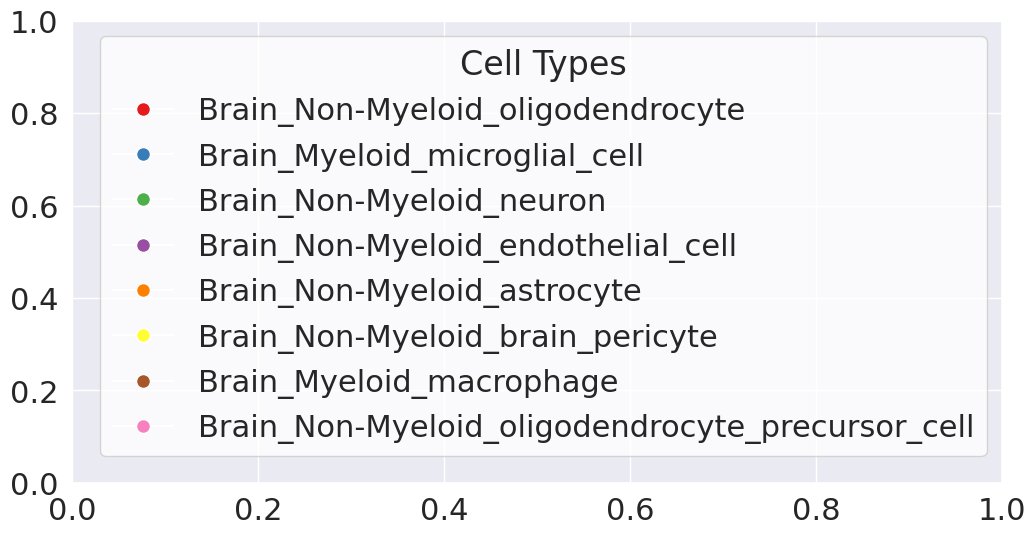

In [27]:
# Add a custom legend for row cell types
# make size bigger plt.fig size
plt.figure(figsize=(12,6))

legend_labels = cell_type_colors.keys()
legend_colors = cell_type_colors.values()

# Make the font of legend larger 
sns.set(font_scale=2)

custom_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(legend_labels, legend_colors)]
legend = plt.legend(handles=custom_legend, title='Cell Types', frameon=True)
legend.get_frame().set_facecolor('white')

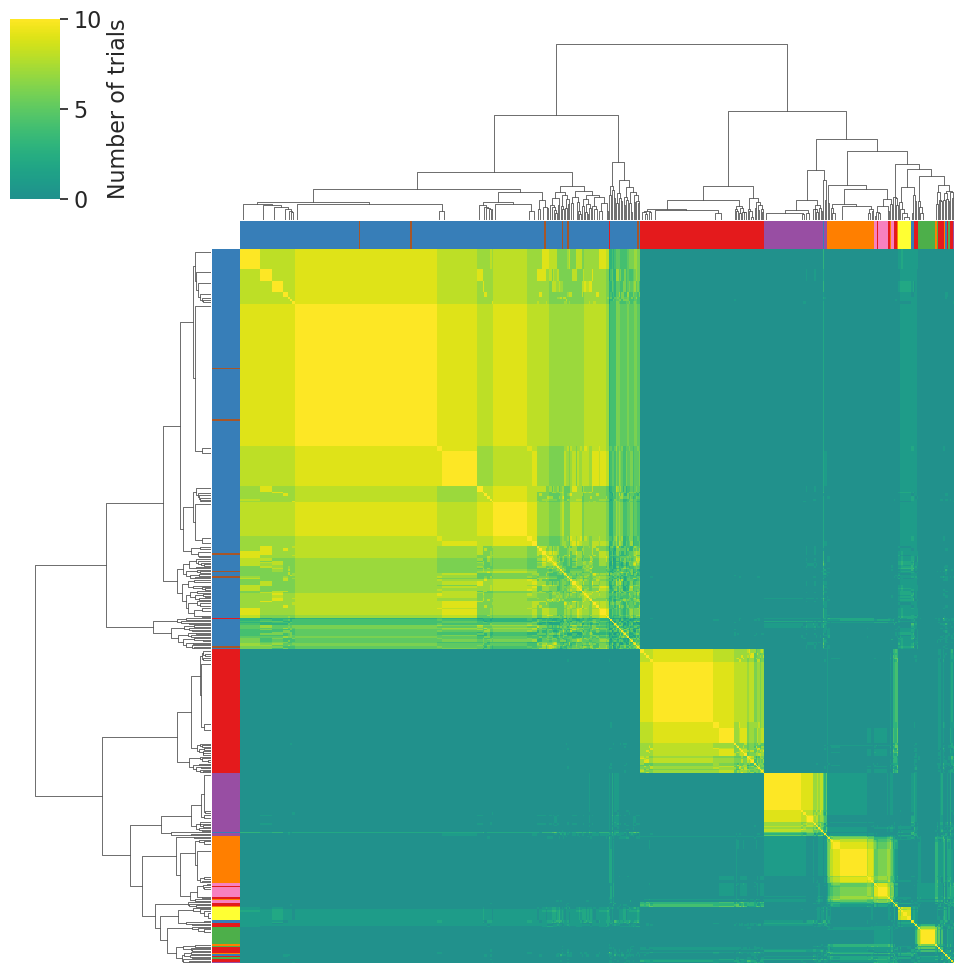

In [28]:
# make also a clustermap of sum_matrices along with their cell types 
# sample 5200 indices from distance matrix
samp_indices = np.random.choice(cell_ids_conversion.shape[0], 500, replace=False)
cell_types_heatmap = cell_ids_conversion.iloc[samp_indices]

color_palette = sns.color_palette("Set1", n_colors=len(cell_types_heatmap['cell_type'].unique()))

# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)

# Obtain cell type labels for every cell in the matrix also 
unique_cell_types = cell_types_heatmap['cell_type'].unique()
num_unique_types = len(unique_cell_types)
colors = sns.color_palette('Set1', n_colors=num_unique_types)  # You can use any color palette
cell_types = cell_types_heatmap.cell_type.values

# Convert cell types to corresponding colors for rows and columns
row_colors = [cell_type_colors[cell_type] for cell_type in cell_types]
col_colors = [cell_type_colors[cell_type] for cell_type in cell_types]

cluster = sns.clustermap(
    data=sum_matrices[samp_indices,:][:,samp_indices],
    method='complete',
    cmap="viridis",
    annot=False,
    fmt=".2f",
    xticklabels=False,
    yticklabels=False,
    figsize=(10, 10),
    center=0,
    row_colors=row_colors,  # Apply row colors
    col_colors=col_colors,   # Apply column colors
        cbar_kws={'label': 'Number of trials'} # Split label over two lines here
    )
cluster.cax.set_ylabel('Number of trials', size=16)
# Increase font size for color bar tick labels:
cbar_ax = cluster.cax
for label in cbar_ax.yaxis.get_ticklabels():
    label.set_size(16)

plt.show()

In [29]:
cell_type_colors = {cell_type: color for cell_type, color in zip(unique_cell_types, colors)}
cell_type_colors

{'Brain_Non-Myeloid_astrocyte': (0.8941176470588236,
  0.10196078431372549,
  0.10980392156862745),
 'Brain_Non-Myeloid_oligodendrocyte': (0.21568627450980393,
  0.49411764705882355,
  0.7215686274509804),
 'Brain_Non-Myeloid_endothelial_cell': (0.30196078431372547,
  0.6862745098039216,
  0.2901960784313726),
 'Brain_Myeloid_microglial_cell': (0.596078431372549,
  0.3058823529411765,
  0.6392156862745098),
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell': (1.0,
  0.4980392156862745,
  0.0),
 'Brain_Non-Myeloid_neuron': (1.0, 1.0, 0.2),
 'Brain_Non-Myeloid_brain_pericyte': (0.6509803921568628,
  0.33725490196078434,
  0.1568627450980392),
 'Brain_Myeloid_macrophage': (0.9686274509803922,
  0.5058823529411764,
  0.7490196078431373)}

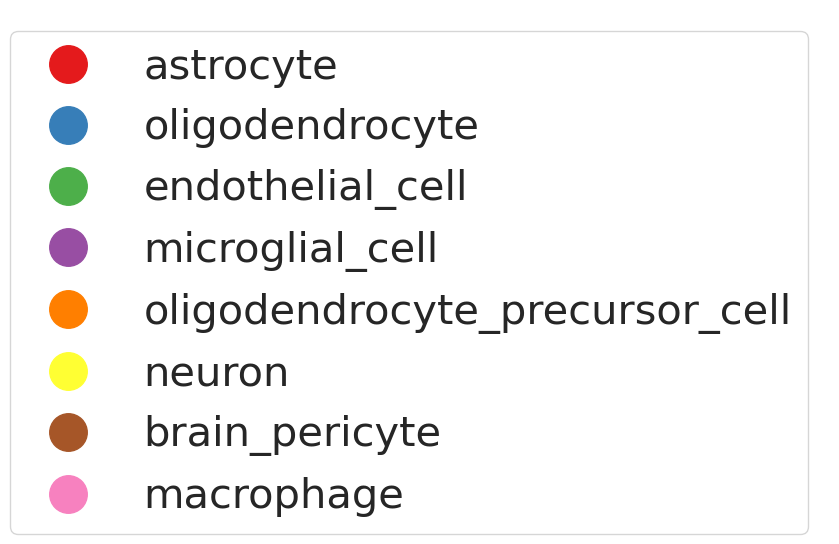

In [30]:
# Create the legend
# make background white 
sns.set_style("white")
# Create the legend
# Create the legend
for cell_type, color in cell_type_colors.items():
    # Extract name after "Myeloid_"
    display_name = cell_type.split("Myeloid_")[-1] if "Myeloid_" in cell_type else cell_type
    plt.plot([], [], 'o', label=display_name, color=color, markersize=27)  # Use 'o' to show the colors clearly

plt.legend(fontsize=30)
plt.axis('off')  # Turn off axis
plt.show()

### Evaluate the learned posteriors

The trial with the highest ELBO was 8


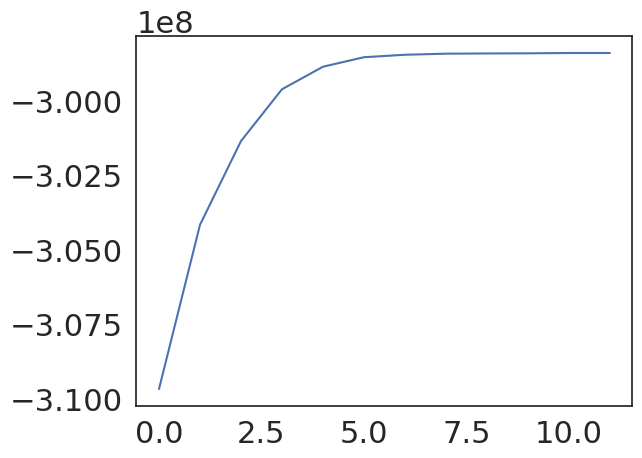

In [31]:
best = np.argmax([ g[-1][-1] for g in results ]) # final ELBO
print(f"The trial with the highest ELBO was {best}")
ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = results[best]
elbos_all = np.array(elbos_all)
plt.plot(elbos_all[1:]); plt.show()

In [32]:
PHI_f_plot = pd.DataFrame(PHI_f.cpu().numpy())
PHI_f_plot['cell_id'] = cell_ids_conversion["cell_type"].to_numpy()

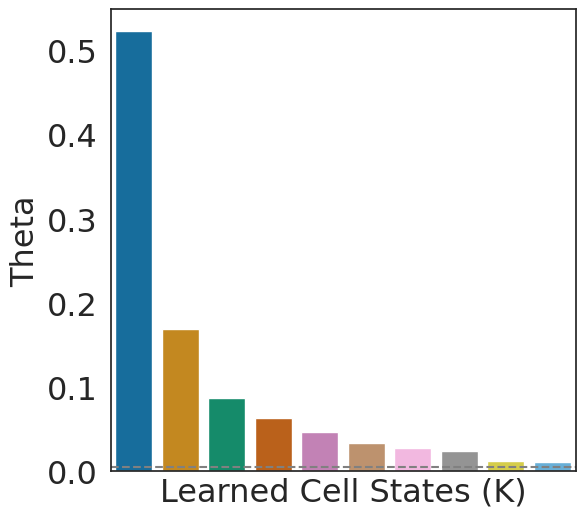

In [33]:
# How much is each cell state is used globally 

# Calculate the total sum of the tensor values
total_sum = torch.sum(GAMMA_f)

# Calculate the percentages
percentages = (GAMMA_f / total_sum) 

# Convert the tensor to a dataframe 
GAMMA_f_plot = pd.DataFrame(percentages.cpu().numpy())
# Give it a colname called theta 
GAMMA_f_plot.columns = ["theta"]
GAMMA_f_plot["cell_state"] = GAMMA_f_plot.index
GAMMA_f_plot.sort_values(by="theta", ascending=False, inplace=True)
GAMMA_f_plot["new_cell_state"] = np.arange(GAMMA_f_plot.shape[0])

sorted_cell_states = GAMMA_f_plot["new_cell_state"].astype(str)

# rename cell_state to be from 0 to K-1 based on order in sorted_cell_states
GAMMA_f_plot.head()

GAMMA_f_plot["new_cell_state"] = pd.Categorical(sorted_cell_states, sorted_cell_states.unique())
GAMMA_f_plot = GAMMA_f_plot.sort_values(by='new_cell_state')

# Create a color mapping for each unique cellassignment
unique_states = GAMMA_f_plot['new_cell_state'].unique()
palette = sns.color_palette("colorblind", len(unique_states))
color_mapping = dict(zip(unique_states, palette))

# Make barplot using sns
plt.figure(figsize=(6, 6))
sns.barplot(x="new_cell_state", y="theta", data=GAMMA_f_plot, palette=color_mapping)
plt.axhline(0.005, ls='--', color='grey')

# Make Y label say Theta and increase font of all labels and ticks
plt.ylabel("Theta", fontsize=23)
plt.xlabel("Learned Cell States (K)", fontsize=23)
plt.xticks([])
plt.yticks(fontsize=23)
plt.show()

In [34]:
GAMMA_f_plot.head()

,theta,cell_state,new_cell_state
4,0.523013,4,0
2,0.169266,2,1
1,0.086745,1,2
3,0.063078,3,3
7,0.047346,7,4


In [35]:
final_data.cell_type.unique()

array(['Brain_Non-Myeloid_brain_pericyte',
       'Brain_Non-Myeloid_oligodendrocyte_precursor_cell',
       'Brain_Non-Myeloid_endothelial_cell',
       'Brain_Non-Myeloid_oligodendrocyte', 'Brain_Non-Myeloid_neuron',
       'Brain_Myeloid_macrophage', 'Brain_Myeloid_microglial_cell',
       'Brain_Non-Myeloid_astrocyte'], dtype=object)

In [36]:
colors

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)]

In [37]:
cell_type_colors

{'Brain_Non-Myeloid_astrocyte': (0.8941176470588236,
  0.10196078431372549,
  0.10980392156862745),
 'Brain_Non-Myeloid_oligodendrocyte': (0.21568627450980393,
  0.49411764705882355,
  0.7215686274509804),
 'Brain_Non-Myeloid_endothelial_cell': (0.30196078431372547,
  0.6862745098039216,
  0.2901960784313726),
 'Brain_Myeloid_microglial_cell': (0.596078431372549,
  0.3058823529411765,
  0.6392156862745098),
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell': (1.0,
  0.4980392156862745,
  0.0),
 'Brain_Non-Myeloid_neuron': (1.0, 1.0, 0.2),
 'Brain_Non-Myeloid_brain_pericyte': (0.6509803921568628,
  0.33725490196078434,
  0.1568627450980392),
 'Brain_Myeloid_macrophage': (0.9686274509803922,
  0.5058823529411764,
  0.7490196078431373)}

                                          cell_type  count  percentage
0                     Brain_Myeloid_microglial_cell   4394    0.562180
1                 Brain_Non-Myeloid_oligodendrocyte   1574    0.201382
2                Brain_Non-Myeloid_endothelial_cell    715    0.091479
3                       Brain_Non-Myeloid_astrocyte    432    0.055271
4                          Brain_Non-Myeloid_neuron    281    0.035952
5  Brain_Non-Myeloid_oligodendrocyte_precursor_cell    203    0.025972
6                  Brain_Non-Myeloid_brain_pericyte    156    0.019959
7                          Brain_Myeloid_macrophage     61    0.007805


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6')])

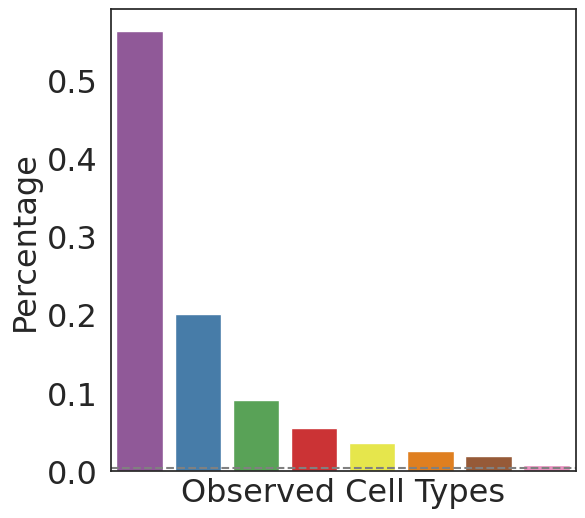

In [38]:
cell_types_summary=cell_ids_conversion['cell_type'].value_counts()
cell_types_summary=pd.DataFrame(cell_types_summary)
cell_types_summary.reset_index(inplace=True)
cell_types_summary.columns=['cell_type','count']
# get percentage of each cell type in the data 
cell_types_summary['percentage']=cell_types_summary['count']/cell_types_summary['count'].sum()
cell_types_summary.sort_values(by='percentage',ascending=False,inplace=True)
print(cell_types_summary)
# plot barplot similar to above with thetas 

color_order = [cell_type_colors[cell_type] for cell_type in cell_types_summary['cell_type']]

# Create the barplot using the cell_type_colors palette
plt.figure(figsize=(6, 6))
sns.barplot(x="cell_type", y="percentage", data=cell_types_summary, palette=color_order)
plt.axhline(0.005, ls='--', color='grey')
plt.ylabel("Percentage", fontsize=23)
plt.xlabel("Observed Cell Types", fontsize=23)
plt.xticks([])
plt.yticks(fontsize=23)

In [39]:
# let's retain only the cell states that are used more than 1% of the time
GAMMA_f_plot = GAMMA_f_plot[GAMMA_f_plot["theta"] > 0.005]
GAMMA_f_plot.index.values

array([4, 2, 1, 3, 7, 6, 8, 5, 9, 0])

In [40]:
# convert PHI_f to a dataframe and add a column with cell ID and cell type 
PHI_f = pd.DataFrame(PHI_f)

# Keep only cell states defined above GAMMA_f_plot.index.values
PHI_f = PHI_f.loc[:, GAMMA_f_plot.index.values]
PHI_f

,4,2,1,3,7,6,8,5,9,0
0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7811,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
7812,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
7813,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
7814,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0


In [41]:
# Add "CellState" to each column 
PHI_f.columns = ["CellState_" + str(i+1) for i in range(PHI_f.shape[1])]
PHI_f['cell_id'] = cell_ids_conversion.cell_id.values
PHI_f['cell_type'] = cell_ids_conversion.cell_type.values
PHI_f.groupby('cell_type').sum()

/scratch/ipykernel_14770/1031914918.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,CellState_1,CellState_2,CellState_3,CellState_4,CellState_5,CellState_6,CellState_7,CellState_8,CellState_9,CellState_10
cell_type,,,,,,,,,,
Brain_Myeloid_macrophage,47.000000,0.000000,0.000000,0.000000,11.000000,0.0,3.0,0.000000,0.0,0.000000
Brain_Myeloid_microglial_cell,4026.955811,2.000000,19.000000,3.000000,276.044067,1.0,23.0,1.000000,13.0,29.000000
Brain_Non-Myeloid_astrocyte,3.000000,5.000000,2.000000,264.008392,37.999939,6.0,8.0,79.999901,8.0,17.991772
Brain_Non-Myeloid_brain_pericyte,0.000000,1.000000,1.000000,0.000000,2.000000,0.0,150.0,0.000000,1.0,1.000000
Brain_Non-Myeloid_endothelial_cell,2.000000,1.000000,628.000000,3.000000,11.000000,2.0,18.0,7.000000,29.0,14.000000
Brain_Non-Myeloid_neuron,0.000000,3.000000,12.000000,2.000000,1.000000,229.0,1.0,17.000000,12.0,4.000000
Brain_Non-Myeloid_oligodendrocyte,9.000000,1309.999878,16.000113,35.000000,31.000000,24.0,16.0,77.000000,32.0,24.000000
Brain_Non-Myeloid_oligodendrocyte_precursor_cell,0.000000,1.000000,0.000000,186.000000,0.000000,0.0,0.0,12.000000,3.0,1.000000


In [42]:
PHI_f.shape # 29 cell states kept 

(7816, 12)

/scratch/ipykernel_14770/2520592141.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
/scratch/ipykernel_14770/2520592141.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


{'CellState_1': ('Brain_Myeloid_microglial_cell', 0.916), 'CellState_10': ('Brain_Non-Myeloid_astrocyte', 0.042), 'CellState_2': ('Brain_Non-Myeloid_oligodendrocyte', 0.832), 'CellState_3': ('Brain_Non-Myeloid_endothelial_cell', 0.878), 'CellState_4': ('Brain_Non-Myeloid_oligodendrocyte_precursor_cell', 0.916), 'CellState_5': ('Brain_Myeloid_macrophage', 0.18), 'CellState_6': ('Brain_Non-Myeloid_neuron', 0.815), 'CellState_7': ('Brain_Non-Myeloid_brain_pericyte', 0.962), 'CellState_8': ('Brain_Non-Myeloid_astrocyte', 0.185), 'CellState_9': ('Brain_Non-Myeloid_neuron', 0.043)}


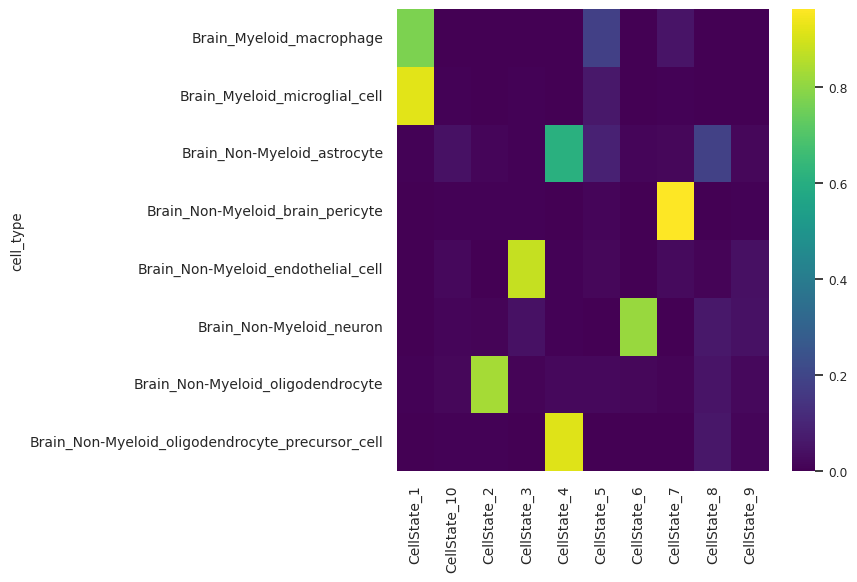

In [43]:
# group by cell_type and sum across each cellstate 
PHI_f.groupby('cell_type').sum()
sum_prop=PHI_f.groupby('cell_type').sum()/PHI_f.groupby('cell_type').count()
# remove cell_id column 
sum_prop=sum_prop.drop(columns=['cell_id'])
#masked_data = np.ma.masked_equal(sum_prop, 0)
sns.set(font_scale=0.8)  # Adjust font size for labels
# make figure bigger 
plt.figure(figsize=(6, 6))
# make font size of xtickts and yticks bigger
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
sns.heatmap(sum_prop, annot=False, fmt=".2f", cmap='viridis')

# now let's give the cell states new labels based on what cell types they are associated with 
# go through sum_prop and for each cell state find the cell type with the highest proportion
# assign that cell type to the cell state
cell_type_labels = {}
for state in sum_prop.columns:
    max_prop = 0
    max_celltype = ''
    for celltype in sum_prop.index:
        if sum_prop.loc[celltype, state] > max_prop:
            max_prop = sum_prop.loc[celltype, state]
            max_celltype = celltype
    cell_type_labels[state] = max_celltype, round(max_prop, 3)
print(cell_type_labels)

In [44]:
# run fisher's exact test to see if the cell states are enriched for any cell types
from scipy.stats import fisher_exact

PHI_f_melt = pd.melt(PHI_f, id_vars=['cell_id', 'cell_type'], value_vars=PHI_f.columns[:-2])

# for each cell, choose cell state with highest probability
PHI_f_melt = PHI_f_melt.sort_values(by=['cell_id', 'value'], ascending=False).drop_duplicates(subset=['cell_id'])
PHI_f_melt.head()

,cell_id,cell_type,variable,value
62527,P9-MAA001894-3_39_F-1-1_Brain_Non-Myeloid_astr...,Brain_Non-Myeloid_astrocyte,CellState_8,1.0
10463,P9-MAA000935-3_8_M-1-1_Brain_Non-Myeloid_oligo...,Brain_Non-Myeloid_oligodendrocyte,CellState_2,1.0
16705,P9-MAA000932-3_11_M-1-1_Brain_Non-Myeloid_endo...,Brain_Non-Myeloid_endothelial_cell,CellState_3,1.0
62526,P9-MAA000930-3_8_M-1-1_Brain_Non-Myeloid_astro...,Brain_Non-Myeloid_astrocyte,CellState_8,1.0
23806,P9-MAA000926-3_9_M-1-1_Brain_Non-Myeloid_oligo...,Brain_Non-Myeloid_oligodendrocyte_precursor_cell,CellState_4,1.0


In [45]:
# run fisher's exact test to test overall association between cell states and cell types
# contingency table

from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(PHI_f_melt['variable'], PHI_f_melt['cell_type'])
contingency_table

chi2, pvalue, _, _ = chi2_contingency(contingency_table)
print(chi2, pvalue)
print(print("P-value: {:.50f}".format(pvalue)))

29821.32224330246 0.0
P-value: 0.00000000000000000000000000000000000000000000000000
None


In [46]:
# change column names to only include cell type the thing aftert 'Myeloid_'
contingency_table.columns = ['_'.join(x.split('_')[2:]) for x in contingency_table.columns]
contingency_table

,macrophage,microglial_cell,astrocyte,brain_pericyte,endothelial_cell,neuron,oligodendrocyte,oligodendrocyte_precursor_cell
variable,,,,,,,,
CellState_1,47,4027,3,0,2,0,9,0
CellState_10,0,29,18,1,14,4,24,1
CellState_2,0,2,5,1,1,3,1310,1
CellState_3,0,19,2,1,628,12,16,0
CellState_4,0,3,264,0,3,2,35,186
CellState_5,11,276,38,2,11,1,31,0
CellState_6,0,1,6,0,2,229,24,0
CellState_7,3,23,8,150,18,1,16,0
CellState_8,0,1,80,0,7,17,77,12


In [47]:
# convert contingency table to proportions 
contingency_table = contingency_table / contingency_table.sum() # represents proportion of cells in cell type that is in cell state 
contingency_table

,macrophage,microglial_cell,astrocyte,brain_pericyte,endothelial_cell,neuron,oligodendrocyte,oligodendrocyte_precursor_cell
variable,,,,,,,,
CellState_1,0.770492,0.916477,0.006944,0.000000,0.002797,0.000000,0.005718,0.000000
CellState_10,0.000000,0.006600,0.041667,0.006410,0.019580,0.014235,0.015248,0.004926
CellState_2,0.000000,0.000455,0.011574,0.006410,0.001399,0.010676,0.832274,0.004926
CellState_3,0.000000,0.004324,0.004630,0.006410,0.878322,0.042705,0.010165,0.000000
CellState_4,0.000000,0.000683,0.611111,0.000000,0.004196,0.007117,0.022236,0.916256
CellState_5,0.180328,0.062813,0.087963,0.012821,0.015385,0.003559,0.019695,0.000000
CellState_6,0.000000,0.000228,0.013889,0.000000,0.002797,0.814947,0.015248,0.000000
CellState_7,0.049180,0.005234,0.018519,0.961538,0.025175,0.003559,0.010165,0.000000
CellState_8,0.000000,0.000228,0.185185,0.000000,0.009790,0.060498,0.048920,0.059113


In [48]:
# reorder variable in contingency table cellstate10 should go after cellstate9
contingency_table = contingency_table.reindex(sorted(contingency_table.columns), axis=1)

# Assuming your dataframe is called df
ordered_indices = [
    'CellState_1', 'CellState_2', 'CellState_3', 'CellState_4',
    'CellState_5', 'CellState_6', 'CellState_7', 'CellState_8',
    'CellState_9', 'CellState_10'
]

contingency_table = contingency_table.reindex(ordered_indices)
contingency_table

,astrocyte,brain_pericyte,endothelial_cell,macrophage,microglial_cell,neuron,oligodendrocyte,oligodendrocyte_precursor_cell
variable,,,,,,,,
CellState_1,0.006944,0.000000,0.002797,0.770492,0.916477,0.000000,0.005718,0.000000
CellState_2,0.011574,0.006410,0.001399,0.000000,0.000455,0.010676,0.832274,0.004926
CellState_3,0.004630,0.006410,0.878322,0.000000,0.004324,0.042705,0.010165,0.000000
CellState_4,0.611111,0.000000,0.004196,0.000000,0.000683,0.007117,0.022236,0.916256
CellState_5,0.087963,0.012821,0.015385,0.180328,0.062813,0.003559,0.019695,0.000000
CellState_6,0.013889,0.000000,0.002797,0.000000,0.000228,0.814947,0.015248,0.000000
CellState_7,0.018519,0.961538,0.025175,0.049180,0.005234,0.003559,0.010165,0.000000
CellState_8,0.185185,0.000000,0.009790,0.000000,0.000228,0.060498,0.048920,0.059113
CellState_9,0.018519,0.006410,0.040559,0.000000,0.002959,0.042705,0.020330,0.014778


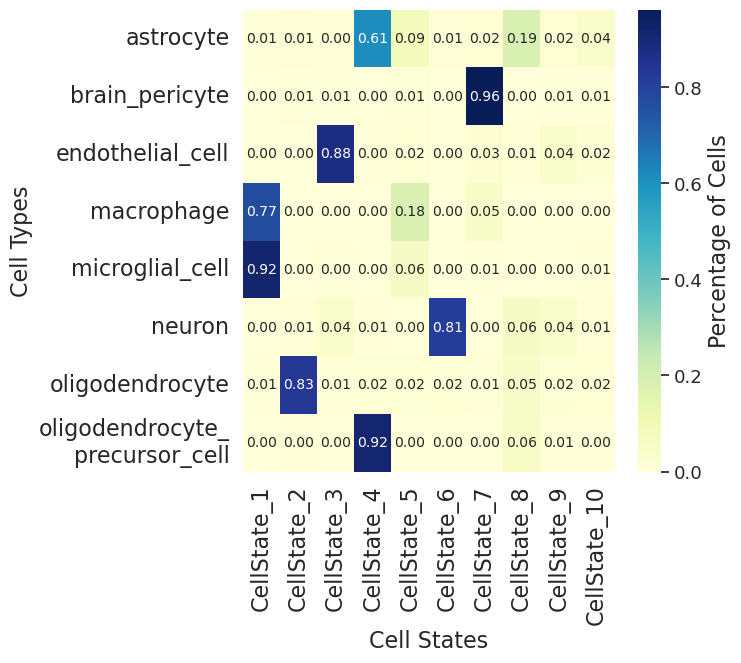

In [49]:
plt.figure(figsize=(6,6))
ax = sns.heatmap(contingency_table.T, annot=True, cmap="YlGnBu", fmt='.2f', annot_kws={"size": 10}, cbar_kws={'label': 'Percentage of Cells'})

# Modifying the label for better visual
labels = [label.get_text().replace("oligodendrocyte_precursor_cell", "oligodendrocyte_\nprecursor_cell") for label in ax.get_yticklabels()]
ax.set_yticklabels(labels)

# Further visual modifications
xlabel = plt.xlabel("Cell States", fontsize=16)
ylabel = plt.ylabel("Cell Types", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Adjusting color bar settings
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=13)
cbar.set_ylabel('Percentage of Cells', fontsize=16)

plt.show()


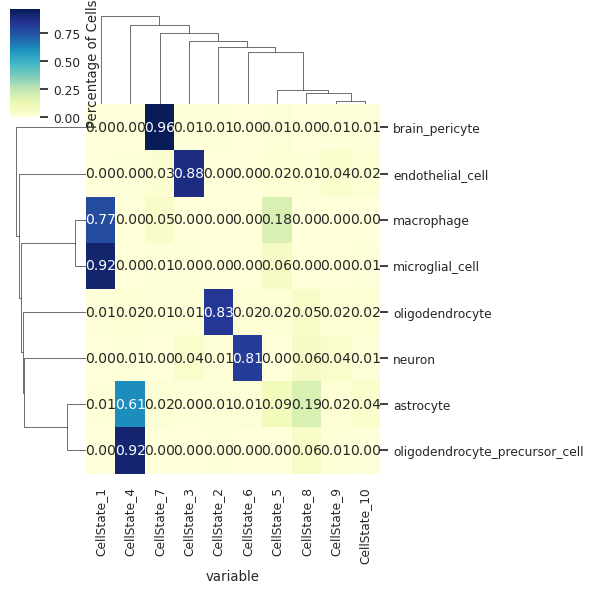

In [50]:
contingency_table

# plot clustermap of contingency table
sns.clustermap(contingency_table.T, cmap="YlGnBu", figsize=(6, 6), annot=True, fmt='.2f', annot_kws={"size": 10}, cbar_kws={'label': 'Percentage of Cells'})

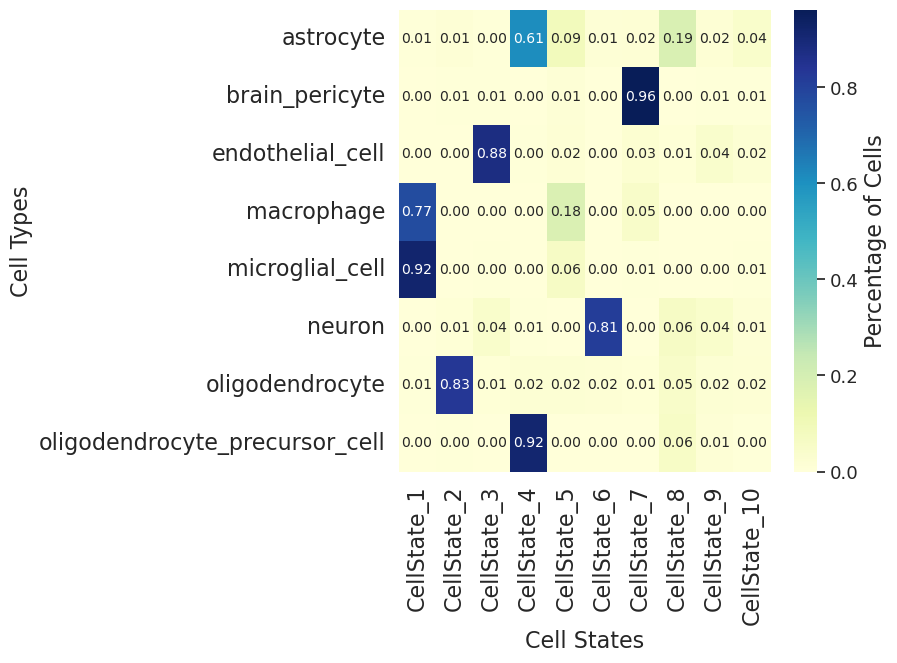

In [51]:
plt.figure(figsize=(6,6))
sns.heatmap(contingency_table.T, annot=True, cmap="YlGnBu", fmt='.2f', annot_kws={"size": 10}, cbar_kws={'label': 'Percentage of Cells'})
xlabel = plt.xlabel("Cell States", fontsize=16)
ylabel = plt.ylabel("Cell Types", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Adjusting color bar settings
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=13)
cbar.set_ylabel('Percentage of Cells', fontsize=16)

plt.show()

## Do differential junction analysis 

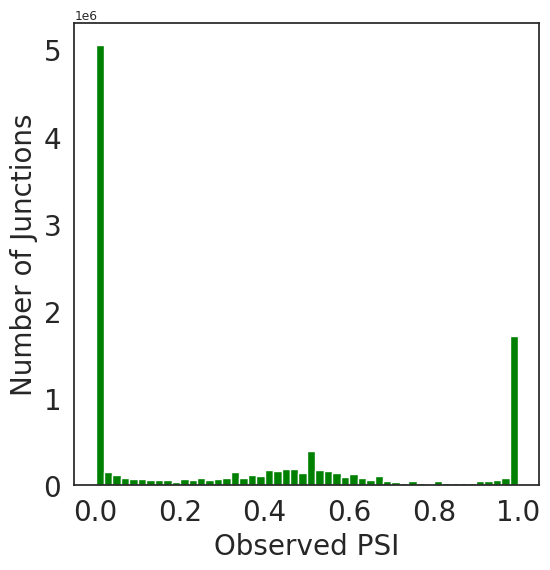

In [52]:
# plot histogram of observed junction usage ratios
plt.figure(figsize=(6, 6))
# make background white
sns.set_style("white")
plt.hist(final_data['juncratio'], bins=50, color='green')
plt.xlabel("Observed PSI", fontsize=20)
plt.ylabel("Number of Junctions", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [53]:
juncs_probs = ALPHA_f / (ALPHA_f+PI_f)   
juncs_probs.shape

torch.Size([16191, 10])

In [54]:
alpha_plus_pi = ALPHA_f+PI_f
alpha_plus_pi.shape

torch.Size([16191, 10])

In [55]:
# Create boolean mask from tensor1
mask = alpha_plus_pi >= 10

# Apply the mask to tensor2 to get filtered values
filtered_values = juncs_probs[mask]

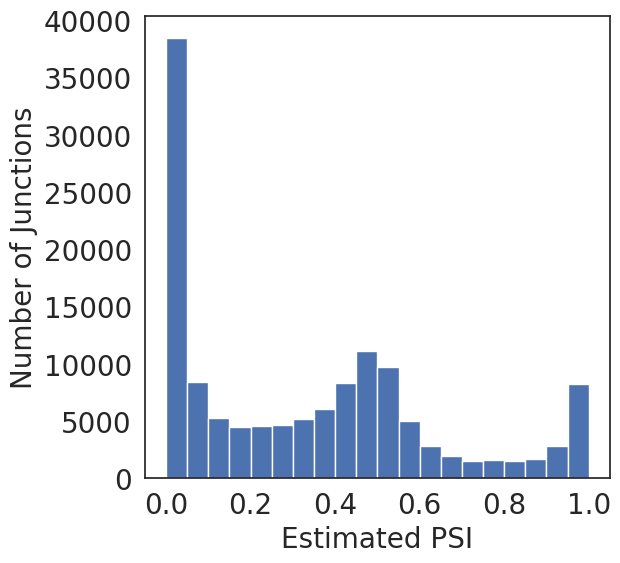

In [56]:
plt.figure(figsize=(6, 6))
# Plot the values
plt.hist(filtered_values.numpy(), bins=20)  # Assuming you want a histogram, adjust as needed
plt.xlabel('Estimated PSI', fontsize=20)
# Set y-label with larger font size (if you need it)
plt.ylabel('Number of Junctions', fontsize=20)  
# Increase tick label size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [57]:
juncs_probs_df = pd.DataFrame(juncs_probs, columns = range(K))
# add "cell_state" to each column name 
juncs_probs_df.columns = ["cell_state_" + str(col+1) for col in juncs_probs_df.columns]
juncs_probs_df["junction_id_index"] = junction_ids_conversion.junction_id_index.values
# convert to juncs_probs to pandas dataframe and calculate mean and std across cell states/topics
juncs_probs_df["junction_id"] = junction_ids_conversion.junction_id.values

In [58]:
# calculate sd deviation for each junction for cell states 0 to 19 
juncs_probs_df["sd"] = juncs_probs_df.iloc[:,0:K].std(axis=1)

In [59]:
juncs_probs_df

,cell_state_1,cell_state_2,cell_state_3,cell_state_4,cell_state_5,cell_state_6,cell_state_7,cell_state_8,cell_state_9,cell_state_10,junction_id_index,junction_id,sd
0,0.725857,0.446268,0.350000,0.422222,0.474903,0.323565,0.480427,0.500000,0.455007,0.483494,0,1_160044753_160070699,0.108241
1,0.274143,0.473314,0.650000,0.485714,0.525097,0.676435,0.519573,0.500000,0.466998,0.488854,1,1_160070803_160075030,0.109251
2,0.361435,0.586192,0.388611,0.559719,0.678905,0.428449,0.425127,0.663945,0.525822,0.228613,2,1_155567681_155572197,0.143056
3,0.980132,0.782374,0.846578,0.453018,0.942649,0.858796,0.609091,0.854660,0.883170,0.668196,3,1_36307836_36316208,0.163769
4,0.361179,0.054733,0.179660,0.014322,0.000047,0.253792,0.001161,0.001516,0.135470,0.004188,4,1_36316327_36317609,0.128017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16186,0.142857,0.034483,0.500000,0.050781,0.500000,0.014164,0.083333,0.500000,0.500000,0.250000,16186,5_115445475_115450214,0.218693
16187,0.066667,0.500000,0.100000,0.060294,0.500000,0.022727,0.500000,0.333333,0.500000,0.020833,16187,1_121087556_121113757,0.224137
16188,0.025641,0.043478,0.006452,0.016929,0.500000,0.095559,0.014286,0.015152,0.500000,0.500000,16188,7_35721679_35725290,0.227904
16189,0.500000,0.500000,0.500000,0.533333,0.500000,0.333333,0.500000,0.500000,0.500000,0.500000,16189,5_110168484_110176316,0.054885


In [60]:
# get likelihood ratio/bayes factor score for ALL junctions 
# let's compare just state X and Y

scores_all_juncs = []
for junc_index in range(juncs_probs.shape[0]):
    a = ALPHA_f[junc_index, ]
    b = PI_f[junc_index, ]
    scores_all_juncs.append(score(a, b).item())

# turn scores_all_juncs into dataframe and add junction_id_index as a column
scores_all_juncs_df = pd.DataFrame(scores_all_juncs, columns = ["score"])
scores_all_juncs_df["junction_id_index"] = junction_ids_conversion.junction_id_index.values
scores_all_juncs_df.sort_values(by="score", ascending=False).head(10)

,score,junction_id_index
548,309506.843750,548
549,309506.843750,549
6124,245067.828125,6124
153,117731.609375,153
886,80075.343750,886
157,70901.484375,157
846,69794.554688,846
1640,68250.562500,1640
518,65783.468750,518
5023,65327.632812,5023


In [61]:
# Compute the logistic score
scores_all_juncs_df["logistic_score"] = 1 / (1 + np.exp(-scores_all_juncs_df["score"]))

# Compute the Bayesian q-value for FDR
scores_all_juncs_df["q_value"] = 1 - scores_all_juncs_df["logistic_score"]
scores_all_juncs_df["significance"] = np.where(scores_all_juncs_df["q_value"] < 0.05, "yes", "no")

In [62]:
scores_all_juncs_df

,score,junction_id_index,logistic_score,q_value,significance
0,125.425781,0,1.000000,0.000000e+00,yes
1,118.287109,1,1.000000,0.000000e+00,yes
2,1456.816406,2,1.000000,0.000000e+00,yes
3,1115.583984,3,1.000000,0.000000e+00,yes
4,2616.380859,4,1.000000,0.000000e+00,yes
...,...,...,...,...,...
16186,24.144791,16186,1.000000,3.266254e-11,yes
16187,20.433273,16187,1.000000,1.336417e-09,yes
16188,47.125458,16188,1.000000,0.000000e+00,yes
16189,12.659546,16189,0.999997,3.177077e-06,yes


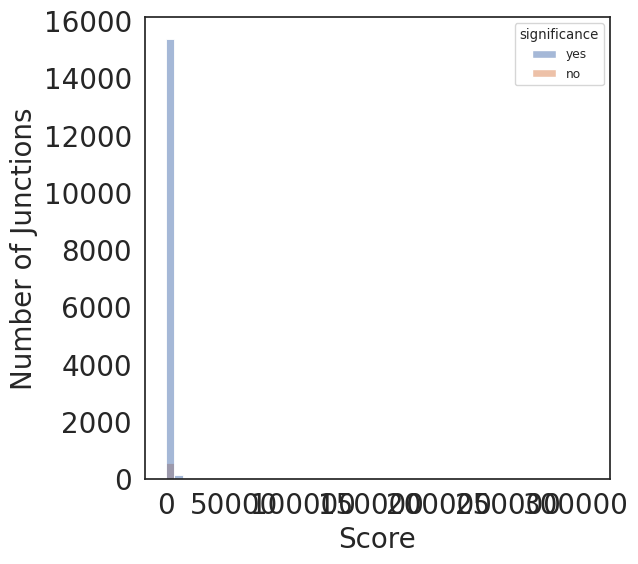

In [63]:
# plot distribution of scores for all junctions colour them by significance
plt.figure(figsize=(6, 6))
# make background white
sns.set_style("white")
sns.histplot(data=scores_all_juncs_df, x="score", hue="significance", bins=50)
plt.xlabel("Score", fontsize=20)
plt.ylabel("Number of Junctions", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


In [64]:
# diff spliced junctions just for microglia cell states 0 and 1
scores_microglia = []
for junc_index in range(juncs_probs.shape[0]):
    a = ALPHA_f[junc_index, [0,4]]
    b = PI_f[junc_index, [0,4]]
    scores_microglia.append(score(a, b).item())

scores_microglia_df = pd.DataFrame(scores_microglia, columns = ["score"])
scores_microglia_df["junction_id_index"] = junction_ids_conversion.junction_id_index.values
scores_microglia_df.sort_values(by="score", ascending=False).head(10)
scores_microglia_df = scores_microglia_df.merge(junction_ids_conversion, on="junction_id_index").sort_values(by="score", ascending=False)
scores_microglia_df["logistic_score"] = 1 / (1 + np.exp(-scores_microglia_df["score"]))

# Compute the Bayesian q-value for FDR
scores_microglia_df["q_value"] = 1 - scores_microglia_df["logistic_score"]
scores_microglia_df["significance"] = np.where(scores_microglia_df["q_value"] < 0.05, "yes", "no")

In [65]:
scores_microglia_df.iloc[886]

score                         167.792969
junction_id_index                   5987
junction_id          7_28767678_28771810
Cluster                             4022
gene_id                            Sirt2
logistic_score                       1.0
q_value                              0.0
significance                         yes
Name: 5987, dtype: object

In [66]:
scores_all_juncs_df = scores_all_juncs_df.merge(junction_ids_conversion, on="junction_id_index").sort_values(by="score", ascending=False)

In [67]:
def quick_junc_plot(junc, simple_data, gene_name=None):
    simple_data_junc = simple_data[simple_data["junction_id_index"] == junc]
    # make violin plot with jitter 
    print(simple_data_junc.cell_type.value_counts())

    sns.violinplot(data = simple_data_junc, x = "junc_ratio", y = "cell_type")
    # make xlim -1 to 1.1
    plt.xlim(-0.2, 1.2)
    # add sample_label to title 
    if gene_name:
        plt.title("Junction:" + str(junc) + " Gene: " + simple_data_junc["gene_id"].values[0])
    # set x axis label to "Junction Usage Ratio (PSI)"
    plt.xlabel("Junction Usage Ratio (PSI)")
    plt.show()

In [68]:
def quick_clust_plot(clust, simple_data, gene_name=None):
    simple_data_junc = simple_data[simple_data["Cluster"] == clust]
    # make violin plot with jitter 
    print(simple_data_junc.cell_type.value_counts())

    # how many cells from each cell type? let's only keep cell types with more than 10 cells here otherwise violin plot doesn't make sense
    # Modify y-tick labels to show only the portion after "Myeloid_" and split "oligodendrocyte_precursor_cell" over two lines

    # set figure size to be 6 by 7 
    plt.figure(figsize=(6, 6))
    sns.violinplot(data = simple_data_junc, x = "junc_ratio", y = "cell_type", hue="junction_id_index")
    # make xlim -1 to 1.1
    plt.xlim(-0.2, 1.2)
    # add sample_label to title 
    if gene_name:
        plt.title("Cluster:" + str(clust) + " Gene: " + simple_data_junc["gene_id"].values[0], fontsize=16)
    # set x axis label to "Junction Usage Ratio (PSI)"
    # increase font size of title and xaxis and yaxis labels
    plt.xlabel("Observed PSI", fontsize=16)
    
    # Modify y-tick labels to show only the portion after "Myeloid_"
    current_labels = [label.get_text() for label in plt.gca().get_yticklabels()]
    new_labels = [label.split("Myeloid_")[-1] if "Myeloid_" in label else label for label in current_labels]
    new_labels = [label.replace("oligodendrocyte_precursor_cell", "oligodendrocyte_\nprecursor_cell") for label in new_labels]
    plt.yticks(plt.yticks()[0], new_labels, fontsize=20)
    plt.ylabel("Cell Type", fontsize=20)
    plt.xlabel("Observed PSI", fontsize=20)
    # increase font size of xticks and yticks
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=16)
    plt.show()

In [69]:
simple_data = final_data[["cell_id_index", "cell_type", "junction_id_index", "junc_count", "cluster_count"]]
simple_data = simple_data.merge(junction_ids_conversion, on="junction_id_index")
simple_data["junc_ratio"] = simple_data["junc_count"] / simple_data["cluster_count"]
simple_data.head()

,cell_id_index,cell_type,junction_id_index,junc_count,cluster_count,junction_id,Cluster,gene_id,junc_ratio
0,0,Brain_Non-Myeloid_brain_pericyte,0,11.0,21,1_160044753_160070699,4,4930523C07Rik,0.523810
1,1,Brain_Non-Myeloid_brain_pericyte,0,53.0,120,1_160044753_160070699,4,4930523C07Rik,0.441667
2,2,Brain_Non-Myeloid_brain_pericyte,0,5.0,19,1_160044753_160070699,4,4930523C07Rik,0.263158
3,4,Brain_Non-Myeloid_brain_pericyte,0,50.0,221,1_160044753_160070699,4,4930523C07Rik,0.226244
4,5,Brain_Non-Myeloid_brain_pericyte,0,5.0,11,1_160044753_160070699,4,4930523C07Rik,0.454545


In [70]:
simple_data[simple_data["Cluster"]== 5903].junction_id.unique()

array(['10_60296002_60296304', '10_60296002_60299097'], dtype=object)

In [71]:
# add percentile rank of score for each junction
scores_all_juncs_df["percentile_rank"] = scores_all_juncs_df["score"].rank(pct=True)
scores_all_juncs_df

,score,junction_id_index,logistic_score,q_value,significance,junction_id,Cluster,gene_id,percentile_rank
548,309506.843750,548,1.000000e+00,0.0,yes,10_60296002_60296304,5903,Psap,0.999969
549,309506.843750,549,1.000000e+00,0.0,yes,10_60296002_60299097,5903,Psap,0.999969
6124,245067.828125,6124,1.000000e+00,0.0,yes,16_85030365_85056323,8680,App,0.999876
153,117731.609375,153,1.000000e+00,0.0,yes,4_139287832_139291002,2028,Capzb,0.999815
886,80075.343750,886,1.000000e+00,0.0,yes,16_84965770_84978063,8674,App,0.999753
...,...,...,...,...,...,...,...,...,...
6070,-18.140625,6070,1.323204e-08,1.0,no,8_107057411_107058046,4752,Nip7,0.000309
939,-18.390625,939,1.030512e-08,1.0,no,17_34026705_34026850,9146,H2-Ke6,0.000247
1608,-18.765625,1608,7.082598e-09,1.0,no,15_79671291_79671896,8260,Tomm22,0.000185
586,-19.218750,586,4.501973e-09,1.0,no,11_3516296_3516485,6501,Selm,0.000124


Brain_Myeloid_microglial_cell                       8688
Brain_Non-Myeloid_oligodendrocyte                   2880
Brain_Non-Myeloid_endothelial_cell                  1148
Brain_Non-Myeloid_astrocyte                          772
Brain_Non-Myeloid_neuron                             496
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     404
Brain_Non-Myeloid_brain_pericyte                     294
Brain_Myeloid_macrophage                             114
Name: cell_type, dtype: int64


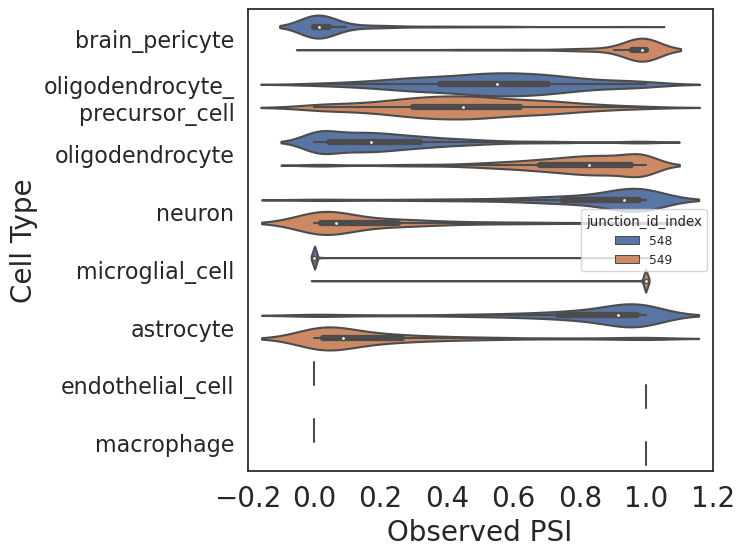

In [72]:
quick_clust_plot(5903, simple_data)

In [73]:
scores_all_juncs_df

,score,junction_id_index,logistic_score,q_value,significance,junction_id,Cluster,gene_id,percentile_rank
548,309506.843750,548,1.000000e+00,0.0,yes,10_60296002_60296304,5903,Psap,0.999969
549,309506.843750,549,1.000000e+00,0.0,yes,10_60296002_60299097,5903,Psap,0.999969
6124,245067.828125,6124,1.000000e+00,0.0,yes,16_85030365_85056323,8680,App,0.999876
153,117731.609375,153,1.000000e+00,0.0,yes,4_139287832_139291002,2028,Capzb,0.999815
886,80075.343750,886,1.000000e+00,0.0,yes,16_84965770_84978063,8674,App,0.999753
...,...,...,...,...,...,...,...,...,...
6070,-18.140625,6070,1.323204e-08,1.0,no,8_107057411_107058046,4752,Nip7,0.000309
939,-18.390625,939,1.030512e-08,1.0,no,17_34026705_34026850,9146,H2-Ke6,0.000247
1608,-18.765625,1608,7.082598e-09,1.0,no,15_79671291_79671896,8260,Tomm22,0.000185
586,-19.218750,586,4.501973e-09,1.0,no,11_3516296_3516485,6501,Selm,0.000124


In [74]:
simple_data_junc = simple_data[simple_data["Cluster"] == 5903]
simple_data_junc

,cell_id_index,cell_type,junction_id_index,junc_count,cluster_count,junction_id,Cluster,gene_id,junc_ratio
845244,0,Brain_Non-Myeloid_brain_pericyte,548,1.0,45,10_60296002_60296304,5903,Psap,0.022222
845245,1,Brain_Non-Myeloid_brain_pericyte,548,3.0,100,10_60296002_60296304,5903,Psap,0.030000
845246,2,Brain_Non-Myeloid_brain_pericyte,548,3.0,8,10_60296002_60296304,5903,Psap,0.375000
845247,3,Brain_Non-Myeloid_brain_pericyte,548,2.0,220,10_60296002_60296304,5903,Psap,0.009091
845248,4,Brain_Non-Myeloid_brain_pericyte,548,7.0,661,10_60296002_60296304,5903,Psap,0.010590
...,...,...,...,...,...,...,...,...,...
860035,7780,Brain_Non-Myeloid_astrocyte,549,0.0,3,10_60296002_60299097,5903,Psap,0.000000
860036,7783,Brain_Non-Myeloid_astrocyte,549,0.0,8,10_60296002_60299097,5903,Psap,0.000000
860037,7786,Brain_Non-Myeloid_astrocyte,549,0.0,32,10_60296002_60299097,5903,Psap,0.000000
860038,7788,Brain_Non-Myeloid_astrocyte,549,0.0,8,10_60296002_60299097,5903,Psap,0.000000


In [75]:
# check wd 
os.getcwd()

'/gpfs/commons/home/kisaev/Leaflet-analysis/tabula_muris_brain/Leaflet'

In [76]:
# generate PSI table from simple_data_junc for just junction_id_index 548
simple_data_junc_548 = simple_data_junc[simple_data_junc["junction_id_index"] == 548]
# save this table as a csv file to plot on top of umap 
simple_data_junc_548.to_csv("simple_data_junc_548.csv")

# generate PSI table from simple_data_junc for just junction_id_index 549
simple_data_junc_549 = simple_data_junc[simple_data_junc["junction_id_index"] == 549]
# save this table as a csv file to plot on top of umap
simple_data_junc_549.to_csv("simple_data_junc_549.csv")

<Axes: >

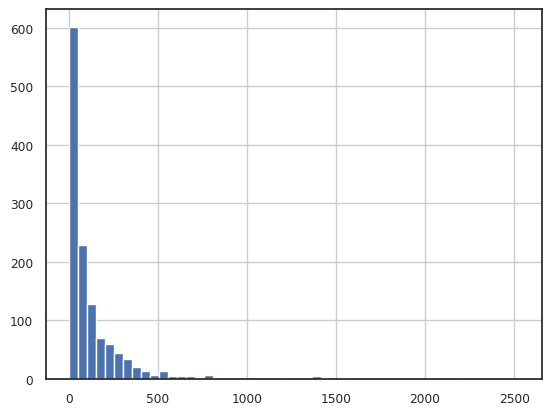

In [77]:
simple_data_junc[simple_data_junc["cell_type"].isin(["Brain_Myeloid_macrophage", "Brain_Non-Myeloid_endothelial_cell"])].cluster_count.hist(bins=50)

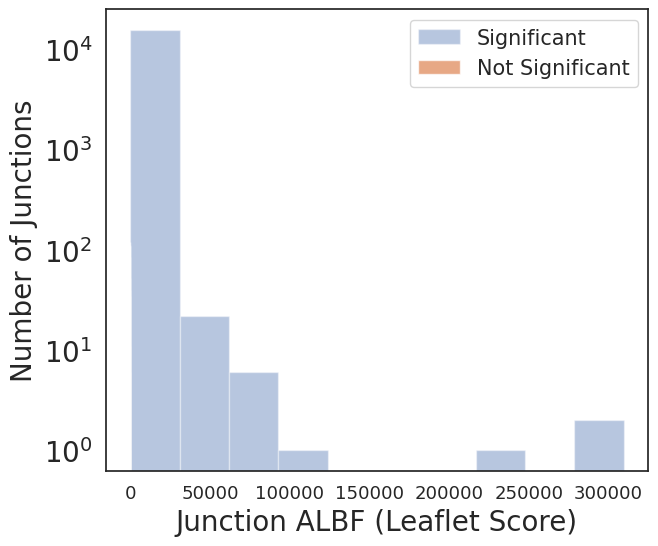

In [78]:
# Assuming you have significance data in scores_all_juncs_df
significant = scores_all_juncs_df[scores_all_juncs_df["significance"] == "yes"]["score"]
not_significant = scores_all_juncs_df[scores_all_juncs_df["significance"] == "no"]["score"]

plt.figure(figsize=(7, 6))

# Plot histograms
plt.hist(significant, bins=10, label='Significant', log=True, alpha=0.4)
plt.hist(not_significant, bins=10, label='Not Significant', log=True, alpha=0.7)

# Adjust labels, legend, and ticks
plt.xlabel("Junction ALBF (Leaflet Score)", fontsize=20)
plt.ylabel("Number of Junctions", fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize=15)

plt.show()


In [79]:
# only show scores for junctions that had decent certainty for ALPHA+BETA  
# turn alpha_plus_pi into dataframe 
alpha_plus_pi_df = pd.DataFrame(alpha_plus_pi, columns = range(K))
alpha_plus_pi_df["junction_id_index"] = alpha_plus_pi_df.index
# now melt alpha_plus_pi_df 
alpha_plus_pi_df_melt = pd.melt(alpha_plus_pi_df, id_vars=['junction_id_index'], value_vars=alpha_plus_pi_df.columns[:-1])
# rename columns to be "cell_state" and "alpha_plus_pi"
alpha_plus_pi_df_melt.columns = ["junction_id_index", "cell_state", "alpha_plus_pi"]
alpha_plus_pi_df_melt.head()

,junction_id_index,cell_state,alpha_plus_pi
0,0,0,642.0
1,1,0,642.0
2,2,0,1115.0
3,3,0,151.0
4,4,0,407.0


In [80]:
print("The number of junctions in the dataset is: " + str(alpha_plus_pi_df_melt.junction_id_index.nunique()))

The number of junctions in the dataset is: 16191


In [81]:
# find the 10th, 20th, 30th... percentiels of alpha_plus_pi
alpha_plus_pi_df_melt["percentile_rank"] = alpha_plus_pi_df_melt["alpha_plus_pi"].rank(pct=True)
# subset dataframe to include only junctions with alpha_plus_pi >= 10
alpha_plus_pi_df_melt = alpha_plus_pi_df_melt[alpha_plus_pi_df_melt["alpha_plus_pi"] >= 50]
print("The number of junctions in the dataset is: " + str(alpha_plus_pi_df_melt.junction_id_index.nunique()))

The number of junctions in the dataset is: 16175


In [82]:
scores_all_juncs_df = scores_all_juncs_df[scores_all_juncs_df["junction_id_index"].isin(alpha_plus_pi_df_melt.junction_id_index.unique())]

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]),
 [Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$')])

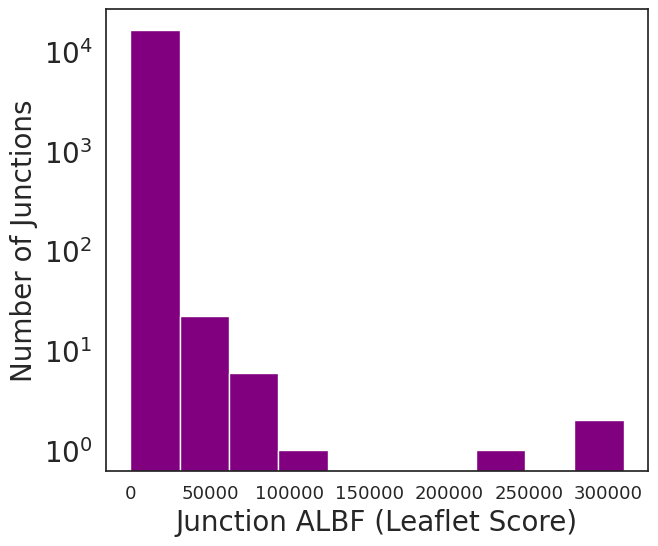

In [83]:
# make a histogram of the scores_all_juncs_df
plt.figure(figsize=(7, 6))
plt.hist(scores_all_juncs_df["score"], bins=10, color="purple", log=True)
plt.xlabel("Junction ALBF (Leaflet Score)", fontsize=20)
plt.ylabel("Number of Junctions", fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=20)

In [84]:
marker_genes = pd.read_csv('/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/scanpy_marker_genes.csv', index_col=0)
# name first column gene_id 
marker_genes.columns = ["gene_id", "cell_type"]
marker_genes.head()

,gene_id,cell_type
0,Olig1,oligodendrocyte precursor cell
1,Gpr37l1,oligodendrocyte precursor cell
2,Pllp,oligodendrocyte precursor cell
3,Bcan,oligodendrocyte precursor cell
4,Tspan3,oligodendrocyte precursor cell


In [85]:
# get top 10% scoring junctions in scores_all_juncs_df 
top10perc = scores_all_juncs_df[scores_all_juncs_df["percentile_rank"] >= 0.9]
print("The number of junctions in the top 10% is: ", top10perc.shape[0])
# how many of them are in genes that appear in the marker_genes dataframe
top10perc = top10perc.merge(marker_genes, on="gene_id")
print("The number of junctions in the top 10% that are in marker genes is: ", top10perc.shape[0])

The number of junctions in the top 10% is:  1620
The number of junctions in the top 10% that are in marker genes is:  107


In [86]:
107/1620

0.06604938271604938

In [87]:
# make a version of the plot that shows that learned junction proportions across cell states 
from scipy.stats import beta

def quick_posterior_junc_plot(junc, ALPHAs, PIs, cell_states=None):
    
    junc_a = ALPHAs[junc, ]
    junc_b = PIs[junc, ]

    if cell_states:
        junc_a = junc_a[cell_states]
        junc_b = junc_b[cell_states]

    # Define a list of colors for the plot
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Add more colors if needed

    # Create a figure and axis for the plot with size 6x6
    fig, ax = plt.subplots(figsize=(5, 5))

    print(junc_a, junc_b)
    
    # Loop through each cell state and plot its beta distribution with a unique color
    for j, (a, b) in enumerate(zip(junc_a, junc_b)):
        
        x = np.linspace(beta.ppf(0.01, a, b),
                        beta.ppf(0.99, a, b), 100)
        
        color = colors[j % len(colors)]  # Cycle through colors if more cell states than colors
        label = f'Cell State {j + 1}'
        
        ax.plot(x, beta.pdf(x, a, b),
                color + '-', lw=2, alpha=0.6, label=label)
        
    # Add labels and legend with increased font size
    ax.set_xlabel('PSI', fontsize=20)
    ax.set_ylabel('Probability Density', fontsize=20)
    ax.set_title('Beta Distributions for junction ' + str(junc), fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    # Place the legend to the right of the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.show()


In [88]:
scores_microglia_df = scores_microglia_df[scores_microglia_df["junction_id_index"].isin(alpha_plus_pi_df_melt.junction_id_index.unique())]
scores_microglia_df.head()

,score,junction_id_index,junction_id,Cluster,gene_id,logistic_score,q_value,significance
549,26874.125000,549,10_60296002_60299097,5903,Psap,1.0,0.0,yes
548,26874.125000,548,10_60296002_60296304,5903,Psap,1.0,0.0,yes
6124,12823.281250,6124,16_85030365_85056323,8680,App,1.0,0.0,yes
886,10737.500000,886,16_84965770_84978063,8674,App,1.0,0.0,yes
7679,8316.666016,7679,12_72223539_72303656,7359,Rtn1,1.0,0.0,yes


tensor([ 1634.0000, 22896.0020]) tensor([20578.0000, 11962.0068])


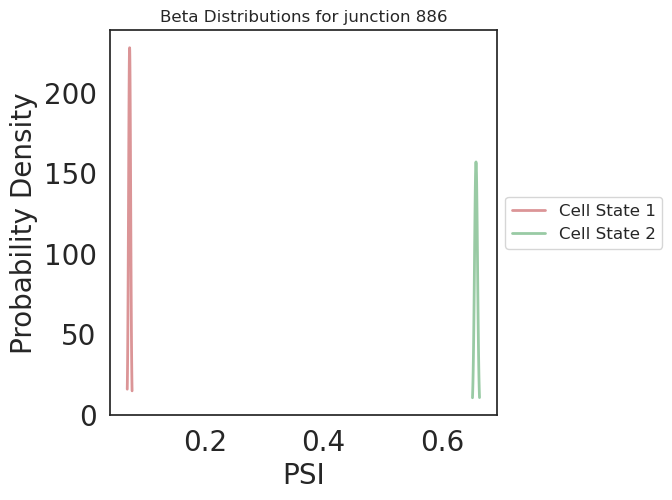

In [89]:
quick_posterior_junc_plot(886, ALPHA_f, PI_f, cell_states=[0,4])

In [90]:
alpha_plus_pi_df_melt[alpha_plus_pi_df_melt["junction_id_index"] == 6917]

,junction_id_index,cell_state,alpha_plus_pi,percentile_rank
6917,6917,0,415099.0,0.999438
23108,6917,1,149048.0,0.997147
39299,6917,2,3982339.0,0.999988
55490,6917,3,215465.0,0.998197
71681,6917,4,143406.0,0.996992
87872,6917,5,377596.0,0.999277
104063,6917,6,17765.0,0.956686
120254,6917,7,155410.0,0.997363
136445,6917,8,100364.0,0.995108
152636,6917,9,90759.0,0.994268


Brain_Non-Myeloid_oligodendrocyte                   1488
Brain_Non-Myeloid_astrocyte                          130
Brain_Myeloid_microglial_cell                        125
Brain_Non-Myeloid_endothelial_cell                   118
Brain_Non-Myeloid_oligodendrocyte_precursor_cell      79
Brain_Non-Myeloid_neuron                              40
Brain_Non-Myeloid_brain_pericyte                      19
Name: cell_type, dtype: int64


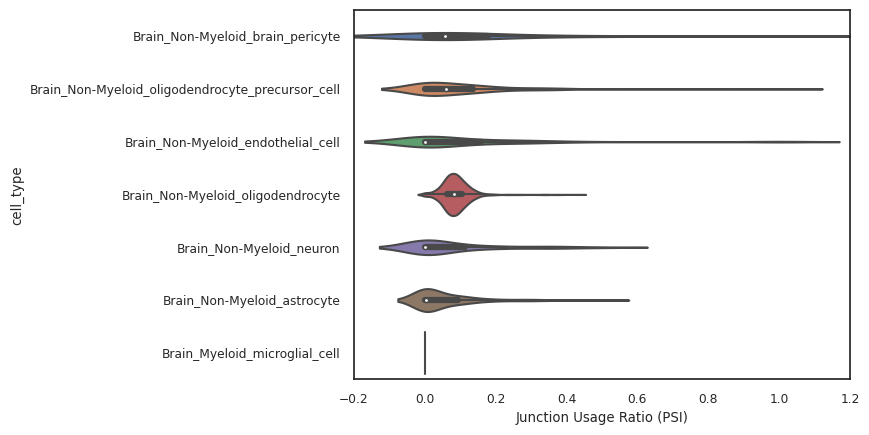

In [91]:
quick_junc_plot(6917, simple_data)

tensor([ 39154.0000,  10915.0078, 343059.0000,  25592.0000,  19595.0000,
         35546.0000,   2267.0000,  15622.0000,   8193.0000,   7729.0000]) tensor([ 375945.,  138133., 3639280.,  189873.,  123811.,  342050.,   15498.,
         139788.,   92171.,   83030.])


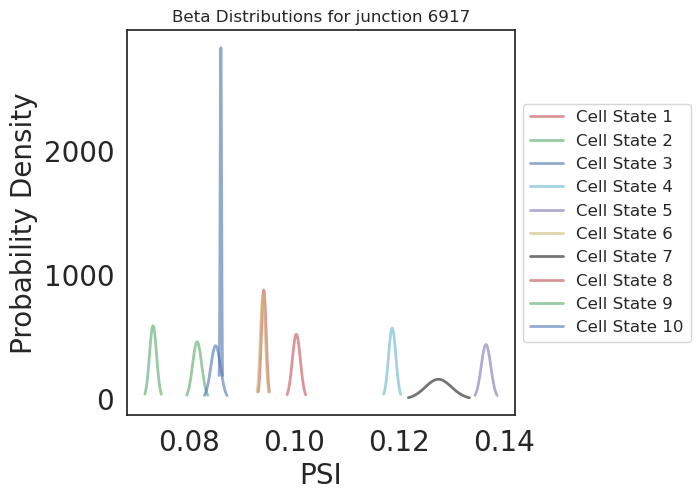

In [92]:
quick_posterior_junc_plot(6917, ALPHA_f, PI_f)

tensor([ 8509.9844,  1377.0000, 52143.0000, 58641.0156,  2984.0845, 24993.9980,
        27251.0000,  3092.9153,  1607.0000,  4952.0000]) tensor([  23550.9883,   50204.0000,  209825.0000,   29369.0117, 1373361.5000,
          26811.0000,    5399.0000,  101197.6094,   36868.0000,    9114.0000])


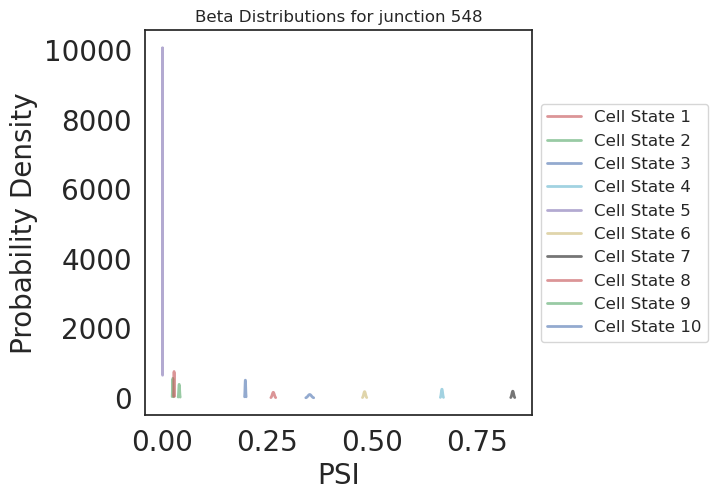

In [93]:
quick_posterior_junc_plot(548, ALPHA_f, PI_f)

In [94]:
PHI_f

,CellState_1,CellState_2,CellState_3,CellState_4,CellState_5,CellState_6,CellState_7,CellState_8,CellState_9,CellState_10,cell_id,cell_type
0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0,A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...,Brain_Non-Myeloid_brain_pericyte
1,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0,A14-MAA000930-3_8_M-1-1_Brain_Non-Myeloid_brai...,Brain_Non-Myeloid_brain_pericyte
2,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0,A14-MAA000947-3_9_M-1-1_Brain_Non-Myeloid_brai...,Brain_Non-Myeloid_brain_pericyte
3,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0,A15-MAA000561-3_10_M-1-1_Brain_Non-Myeloid_bra...,Brain_Non-Myeloid_brain_pericyte
4,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0,A19-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...,Brain_Non-Myeloid_brain_pericyte
...,...,...,...,...,...,...,...,...,...,...,...,...
7811,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,P7-MAA000564-3_10_M-1-1_Brain_Non-Myeloid_astr...,Brain_Non-Myeloid_astrocyte
7812,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,P7-MAA000947-3_9_M-1-1_Brain_Non-Myeloid_astro...,Brain_Non-Myeloid_astrocyte
7813,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,P8-MAA000560-3_10_M-1-1_Brain_Non-Myeloid_astr...,Brain_Non-Myeloid_astrocyte
7814,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,P9-MAA000930-3_8_M-1-1_Brain_Non-Myeloid_astro...,Brain_Non-Myeloid_astrocyte


In [95]:
# save cell assignments to file for downstream analysis
output_dir = '/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/'

# BBmixture model cell assignments
output_file = os.path.join(output_dir, 'Leaflet_BBmixture.csv')
PHI_f.to_csv(output_file, index=True, header=True)
print('Saved Leaflet latent cell states to {}'.format(output_file))

Saved Leaflet latent cell states to /gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/Leaflet_BBmixture.csv


## Evaluate likelihood on validation set to determine best K

In [96]:
# validation data 
input_files_folder = '/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/validation/'

val_data, val_coo_counts_sparse, val_coo_cluster_sparse, val_cell_ids_conversion, val_junction_ids_conversion = load_cluster_data.load_cluster_data(
    input_folder = input_files_folder, has_genes="yes")
cell_index_tensor_val, junc_index_tensor_val, my_data_val = make_torch_data(val_data, **float_type)

Reading in data from folder ...
/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/validation/
Finished reading in data from folder ...
['Brain_Non-Myeloid_oligodendrocyte_precursor_cell'
 'Brain_Non-Myeloid_Bergmann_glial_cell'
 'Brain_Non-Myeloid_endothelial_cell' 'Brain_Myeloid_microglial_cell'
 'Brain_Non-Myeloid_brain_pericyte' 'Brain_Non-Myeloid_oligodendrocyte'
 'Brain_Non-Myeloid_astrocyte' 'Brain_Non-Myeloid_neuron'
 'Brain_Myeloid_macrophage']
1571
15824
                                             cell_id  Cluster  Cluster_Counts  \
0  A10-MAA000564-3_10_M-1-1_Brain_Non-Myeloid_oli...        2              20   
1  A10-MAA000564-3_10_M-1-1_Brain_Non-Myeloid_oli...       10              15   
2  A10-MAA000564-3_10_M-1-1_Brain_Non-Myeloid_oli...       25              47   
3  A10-MAA000564-3_10_M-1-1_Brain_Non-Myeloid_oli...       44             209   
4  A10-MAA000564-3_10_M-1-1_Brain_Non-Myeloid_oli...       44             209   

   

In [97]:
import betabinomo_mix_singlecells
reload(betabinomo_mix_singlecells)

<module 'betabinomo_mix_singlecells' from '/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/betabinomo_mix_singlecells.py'>

In [98]:
# set random seed
torch.manual_seed(0)

num_trials = 1 # should also be an argument that gets fed in
num_iters = 40 # should also be an argument that gets fed in
K = 12

# loop over the number of trials (for now just testing using one trial but in general need to evaluate how performance is affected by number of trials)
#reload(betabinomo_mix_singlecells)

start_time = time.time()
all_results_k = []
all_ll_k = []

for k in range(K):
    k = k + 1
    print(f"Running with {k} cell states")
    results = [ betabinomo_mix_singlecells.calculate_CAVI(k, my_data, float_type, hypers, init_labels = None, num_iterations = num_iters) 
           for t in range(num_trials) ]
    
    all_results_k.append(results)
    ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = results[0]
    juncs_probs = ALPHA_f / (ALPHA_f+PI_f)   
    juncs_probs_df = pd.DataFrame(juncs_probs.numpy())
    # rename columns to be "state_0", "state_1", etc.
    juncs_probs_df.columns = ["state_" + str(i) for i in range(juncs_probs_df.shape[1])]
    juncs_probs_df["junction_id_index"] = juncs_probs_df.index

    # merge with val_data 
    val_data_run = val_data.merge(juncs_probs_df, on="junction_id_index")
    theta = GAMMA_f / GAMMA_f.sum()
    theta = theta.cpu().numpy()

    # evaluate predictive log likelihood on validation set 
    print("Calculating predictive log likelihood on validation set")
    ll = betabinomo_mix_singlecells.calculate_predictive_lik(theta, val_data_run)
    all_ll_k.append(ll)
    print(f"Predictive log likelihood on validation set is {ll}")

# write the above line use fstring
print(f"This took {time.time() - start_time} seconds")

Running with 1 cell states
Initialize VI params
Initializing variational parameters with N = 7816 cells and J = 16191 junctions
Got the initial ELBO ^
ELBO converged @ -309838080.0 CAVI iteration # 2 complete
Finished CAVI!
Calculating predictive log likelihood on validation set


TypeError: calculate_predictive_lik() missing 2 required positional arguments: 'y' and 'n'

In [ ]:
(all_ll_k == np.max(all_ll_k))

In [ ]:
all_ks = pd.DataFrame(np.array(all_ll_k))
all_ks["k"] = all_ks.index
all_ks.columns = ["ll", "k"]
all_ks.sort_values("ll", ascending=False)

In [ ]:
import matplotlib.pyplot as plt

# Given data
data = [
    (10, -3.759537e+07),
    (11, -3.792445e+07),
    (9, -3.812037e+07),
    (7, -3.837194e+07),
    (8, -3.856408e+07),
    (6, -3.934490e+07),
    (5, -3.983091e+07),
    (4, -4.040786e+07),
    (2, -4.199341e+07),
    (3, -4.218076e+07),
    (1, -4.448278e+07),
    (0, -4.958535e+07)
]

# Unpack data into separate lists for x and y values
x_values, y_values = zip(*data)

# Create a bar plot
plt.bar(x_values, y_values, color='blue')

# Add labels and title
plt.xlabel('k', fontsize=14)
plt.ylabel('Log Likelihood (ll)', fontsize=14)
plt.title('Log Likelihood vs k', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()
